# Jupyter Notebook of case results

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.interpolate
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import meshio 
import os 
from iapws import IAPWS97
import warnings
warnings.filterwarnings("ignore")
from vtk import *
from vtk.util import numpy_support as VN
#===============================================================
# config font
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
sec_year=86400*365
cm2inch=1 #0.393701
dpi=600
# path----------
path_figures='../../../../../_figures'

## Read results

1. Using `foamToVTK` utility convert OpenFOAM result to VTK format, e.g. `foamToVTK -time '823328000000'  -useTimeName`
2. Read VTK file (Ustructured data) using [meshio](https://github.com/nschloe/meshio)
3. Triangulate the unstructured data using `mpl.tri.Triangulation`[(doc)](https://matplotlib.org/3.1.0/api/tri_api.html#matplotlib.tri.Triangulation) function

In [2]:
# read vtk file generated by `foamToVTK`
# vtk unstructured mesh
def readVTK_2D(vtkfile,positiveDepth=True,scale_coord=1):
    data=meshio.read(vtkfile)
    points=data.points
    x,y=points[:,0]*scale_coord,points[:,1]*scale_coord
    if(positiveDepth):
        y=-y
    cells=data.cells[0].data
    triangles=cells[:,0:3]
    point_data=data.point_data
    cell_data=data.cell_data
    cell_perm=cell_data['permeability'][0]
    trimesh=[]
    if(cells.shape[1]>3):
        trimesh=mpl.tri.Triangulation(x,y)
    else:
        trimesh=mpl.tri.Triangulation(x,y,triangles)
    return trimesh, point_data,cell_data

## Maximum vent temperature changes with time

In [3]:
path_results='../HS1000/results' 
permeabilities=[1E-16,3E-16,5E-16,8E-16,1E-15,2E-15,3E-15,4E-15,6E-15,8E-15,1E-14,3E-14,6E-14,8E-14,1E-13,2E-13,3E-13,4E-13,1E-12]
ventT={'min':[],'max':[],'mean':[]}
for key in ventT.keys():
    ventT[key]=np.zeros_like(permeabilities)

 1E-12, 103, 170, 228
 4E-13, 150, 220, 280
 3E-13, 168, 233, 296
 2E-13, 205, 258, 313
 1E-13, 252, 301, 336
 8E-14, 244, 304, 344
 6E-14, 265, 318, 352
 3E-14, 342, 344, 347
 1E-14, 317, 322, 328
 8E-15, 332, 332, 332
 6E-15, 345, 345, 345
 4E-15, 357, 357, 357
 3E-15, 362, 362, 362
 2E-15, 372, 373, 373
 1E-15, 380, 380, 381
 8E-16, 377, 378, 378
 5E-16, 356, 359, 361
 3E-16, 331, 331, 331
 1E-16, 189, 190, 191


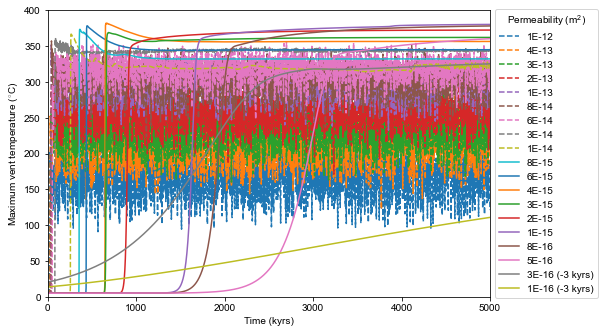

In [5]:
fig=plt.figure(figsize=(8.5,4.95))
ax=plt.gca()
ls='solid'
start_steadState=-200
for i in range(len(permeabilities)-1,-1,-1):
    perm=permeabilities[i]
    fname_ventT=str('%s/ventT_%.0E.txt'%(path_results,perm))
    data=np.loadtxt(fname_ventT)
    t=data[:,0]
    T=data[:,1]
    ventT['mean'][i]=np.mean(T[start_steadState:-1])
    ventT['min'][i]=np.min(T[start_steadState:-1])
    ventT['max'][i]=np.max(T[start_steadState:-1])
    print(' %.0E, %.0f, %.0f, %.0f'%(perm, ventT['min'][i], ventT['mean'][i], ventT['max'][i]))
    if(i//10 ==0):
        ls='solid'
    elif(i//10 == 1):
        ls='dashed'
    elif(i//10 == 2):
        ls='dotted'
    if(perm<5E-16):
        ax.plot(t-3000,T,label='%.0E (-3 kyrs)'%(perm),ls=ls)
    else:
        ax.plot(t,T,label='%.0E'%(perm),ls=ls)
ax.legend(ncol=1,bbox_to_anchor=(1,-0.02),loc='lower left',title='Permeability (m$^{\mathregular{2}}$)')
ax.set_xlabel('Time (kyrs)')
ax.set_ylabel('Maximum vent temperature ($^{\circ}$C)')
ax.set_xlim(0,5000)
ax.set_ylim(0,400)

plt.tight_layout()
plt.savefig('%s/ventT_time_perm.pdf'%(path_figures))
plt.savefig('%s/ventT_time_perm.jpg'%(path_figures),dpi=400)
plt.show()

## Vent temperature as a function of permeability

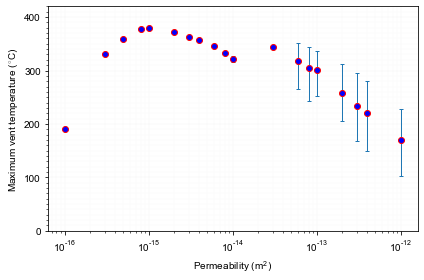

In [16]:
fig=plt.figure(figsize=(6,4))
ax=plt.gca()
# ax.semilogx(permeabilities,ventT['mean'],'o')
ax.errorbar(permeabilities,ventT['mean'], yerr=[ventT['mean']-ventT['min'], ventT['max']-ventT['mean']],
            capsize=2, elinewidth=1, marker='o',mec='r',mfc='b', linestyle='none')
ax.set_xscale('log')

ax.set_xlabel('Permeability (m$^{\mathregular{2}}$)')
ax.set_ylabel('Maximum vent temperature ($^{\circ}$C)')
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0, subs=(1.0,),numticks=20))
ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.linspace(0.1,0.9,9),numticks=20))
ax.grid(which='major',color='gray',lw=0.05)
ax.grid(which='minor',color='lightgray',lw=0.05)
ax.set_ylim(0,420)

plt.tight_layout()
plt.savefig('%s/ventT_perm.pdf'%(path_figures))
plt.savefig('%s/ventT_perm.svg'%(path_figures))
plt.show()